In [1]:
!pip3 install -r requirements.txt

In [2]:
import warnings
from collections import Counter

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [4]:
warnings.filterwarnings("ignore")

## Pre-processing for BLF Features

In [5]:
with open('./Features/blf_features.txt') as f:
    lines = f.readlines()

In [6]:
spectral = []
deltaspec = []
varspec = []
logfluc = []
corr = []
speccon = []
for line in lines:

    if line.startswith('SPECTRAL:'):
        spectral.append(list(map(float, line.replace(
            'SPECTRAL:', '').rstrip('\n').strip().split(' '))))
    if line.startswith('DELTASPECTRAL:'):
        deltaspec.append(list(map(float, line.replace(
            'DELTASPECTRAL:', '').rstrip('\n').strip().split(' '))))
    if line.startswith('VARIANCEDELTASPECTRAL:'):
        varspec.append(list(map(float, line.replace(
            'VARIANCEDELTASPECTRAL:', '').rstrip('\n').strip().split(' '))))
    if line.startswith('LOGARITHMICFLUCTUATION:'):
        logfluc.append(list(map(float, line.replace(
            'LOGARITHMICFLUCTUATION:', '').rstrip('\n').strip().split(' '))))
    if line.startswith('CORRELATION:'):
        corr.append(list(map(float, line.replace(
            'CORRELATION:', '').rstrip('\n').strip().split(' '))))
    if line.startswith('SPECTRALCONTRAST:'):
        speccon.append(list(map(float, line.replace(
            'SPECTRALCONTRAST:', '').rstrip('\n').strip().split(' '))))

In [7]:
blf = pd.DataFrame(
    {'SPECTRAL': spectral,
     'DELTASPECTRAL': deltaspec,
     'VARIANCEDELTASPECTRAL': varspec,
     'LOGARITHMICFLUCTUATION': logfluc,
     'CORRELATION': corr,
     'SPECTRALCONTRAST': speccon
     })

In [8]:
blf.head(2)

,SPECTRAL,DELTASPECTRAL,VARIANCEDELTASPECTRAL,LOGARITHMICFLUCTUATION,CORRELATION,SPECTRALCONTRAST
0,"[-0.0315295, -0.0255247, -0.0223557, -0.019199...","[0.000946698, 0.0019733, 0.00280769, 0.0037678...","[0.0023107, 0.00245491, 0.00256964, 0.00268689...","[17.2747, 27.0661, 40.696, 89.8944, 110.846, 8...","[0.00049472, 0.000352754, 0.000331897, 0.00032...","[0.019277, 0.0243692, 0.0271908, 0.0282635, 0...."
1,"[-0.0290814, -0.0236205, -0.0205705, -0.018726...","[0.00100166, 0.00169647, 0.00264387, 0.0035443...","[0.00239419, 0.00241911, 0.00243979, 0.0025311...","[13.1384, 20.8441, 27.6096, 35.502, 40.2289, 4...","[0.000270678, 0.000149724, 0.000109612, 8.0102...","[0.0254623, 0.0282966, 0.029933, 0.0317052, 0...."


In [9]:
features_blf = ['SPECTRAL', 'DELTASPECTRAL', 'VARIANCEDELTASPECTRAL',
                'LOGARITHMICFLUCTUATION', 'CORRELATION', 'SPECTRALCONTRAST']
#blf_features = pd.DataFrame()

for i in range(len(features_blf)):
    feature = blf[features_blf[i]].apply(pd.Series)
    feature = feature.rename(
        columns=lambda x: features_blf[i]+'_BLOCK_'+str(x+1))
    if i == 0:
        blf_features = feature
    else:
        blf_features = pd.concat([blf_features, feature], axis=1)

In [10]:
blf_features

,SPECTRAL_BLOCK_1,SPECTRAL_BLOCK_2,SPECTRAL_BLOCK_3,SPECTRAL_BLOCK_4,SPECTRAL_BLOCK_5,SPECTRAL_BLOCK_6,SPECTRAL_BLOCK_7,SPECTRAL_BLOCK_8,SPECTRAL_BLOCK_9,SPECTRAL_BLOCK_10,...,SPECTRALCONTRAST_BLOCK_791,SPECTRALCONTRAST_BLOCK_792,SPECTRALCONTRAST_BLOCK_793,SPECTRALCONTRAST_BLOCK_794,SPECTRALCONTRAST_BLOCK_795,SPECTRALCONTRAST_BLOCK_796,SPECTRALCONTRAST_BLOCK_797,SPECTRALCONTRAST_BLOCK_798,SPECTRALCONTRAST_BLOCK_799,SPECTRALCONTRAST_BLOCK_800
0,-0.031530,-0.025525,-0.022356,-0.019200,-0.016703,-0.014133,-0.012213,-0.009896,-0.007247,-0.004711,...,0.016278,0.016670,0.017292,0.017690,0.018070,0.018714,0.019189,0.019672,0.020845,0.022252
1,-0.029081,-0.023620,-0.020570,-0.018727,-0.016657,-0.014965,-0.013226,-0.011205,-0.008928,-0.006817,...,0.018374,0.018874,0.019224,0.019684,0.019789,0.021225,0.021963,0.023364,0.025303,0.027977
2,-0.029325,-0.024472,-0.021190,-0.018394,-0.016604,-0.014580,-0.012933,-0.011341,-0.008591,-0.006328,...,0.020599,0.020898,0.021218,0.021848,0.022268,0.023208,0.023924,0.025104,0.026706,0.029759
3,-0.030254,-0.024281,-0.020952,-0.018408,-0.015877,-0.013617,-0.011455,-0.008385,-0.004644,-0.001433,...,0.023702,0.024199,0.024936,0.025797,0.027130,0.028170,0.029745,0.031424,0.033475,0.036691
4,-0.029256,-0.024000,-0.020924,-0.018811,-0.016465,-0.014760,-0.012484,-0.010376,-0.007719,-0.004785,...,0.018999,0.019265,0.020043,0.020455,0.021041,0.021922,0.022816,0.024183,0.025603,0.027584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1350,-0.020738,-0.015658,-0.012821,-0.010344,-0.008233,-0.005605,-0.003298,-0.000101,0.003155,0.006043,...,0.021210,0.021773,0.022435,0.023177,0.024264,0.025236,0.026789,0.028831,0.031713,0.034892
1351,-0.029872,-0.024420,-0.020613,-0.018222,-0.016303,-0.014631,-0.012952,-0.010924,-0.008923,-0.006004,...,0.017505,0.017726,0.018455,0.018698,0.019614,0.020082,0.021025,0.021962,0.024478,0.026518
1352,-0.030317,-0.024644,-0.021444,-0.018990,-0.016740,-0.015121,-0.013449,-0.011495,-0.008726,-0.005827,...,0.018468,0.018861,0.019385,0.019747,0.020350,0.021293,0.021715,0.022657,0.023249,0.025166
1353,-0.026280,-0.021658,-0.018518,-0.016158,-0.014376,-0.012566,-0.010694,-0.008907,-0.006480,-0.004236,...,0.024772,0.025626,0.026451,0.027651,0.028659,0.029878,0.031857,0.033005,0.034815,0.037853


-------

### Adding Mood and Song ID

In [11]:
blf_similarities = pd.read_csv(
    './Features/blf_similarities.txt', sep='\t', nrows=1355)
blf_similarities = blf_similarities.drop(blf_similarities.columns[0], axis=1)
blf_similarities.columns = ['SONG_ID']
# blf_similarities.head(2)

In [12]:
blf = blf_similarities.join(blf_features)

In [13]:
blf.head()

,SONG_ID,SPECTRAL_BLOCK_1,SPECTRAL_BLOCK_2,SPECTRAL_BLOCK_3,SPECTRAL_BLOCK_4,SPECTRAL_BLOCK_5,SPECTRAL_BLOCK_6,SPECTRAL_BLOCK_7,SPECTRAL_BLOCK_8,SPECTRAL_BLOCK_9,...,SPECTRALCONTRAST_BLOCK_791,SPECTRALCONTRAST_BLOCK_792,SPECTRALCONTRAST_BLOCK_793,SPECTRALCONTRAST_BLOCK_794,SPECTRALCONTRAST_BLOCK_795,SPECTRALCONTRAST_BLOCK_796,SPECTRALCONTRAST_BLOCK_797,SPECTRALCONTRAST_BLOCK_798,SPECTRALCONTRAST_BLOCK_799,SPECTRALCONTRAST_BLOCK_800
0,375706,-0.031530,-0.025525,-0.022356,-0.019200,-0.016703,-0.014133,-0.012213,-0.009896,-0.007247,...,0.016278,0.016670,0.017292,0.017690,0.018070,0.018714,0.019189,0.019672,0.020845,0.022252
1,1000226,-0.029081,-0.023620,-0.020570,-0.018727,-0.016657,-0.014965,-0.013226,-0.011205,-0.008928,...,0.018374,0.018874,0.019224,0.019684,0.019789,0.021225,0.021963,0.023364,0.025303,0.027977
2,1001319,-0.029325,-0.024472,-0.021190,-0.018394,-0.016604,-0.014580,-0.012933,-0.011341,-0.008591,...,0.020599,0.020898,0.021218,0.021848,0.022268,0.023208,0.023924,0.025104,0.026706,0.029759
3,37580,-0.030254,-0.024281,-0.020952,-0.018408,-0.015877,-0.013617,-0.011455,-0.008385,-0.004644,...,0.023702,0.024199,0.024936,0.025797,0.027130,0.028170,0.029745,0.031424,0.033475,0.036691
4,37586,-0.029256,-0.024000,-0.020924,-0.018811,-0.016465,-0.014760,-0.012484,-0.010376,-0.007719,...,0.018999,0.019265,0.020043,0.020455,0.021041,0.021922,0.022816,0.024183,0.025603,0.027584


## Train Set

In [14]:
moods_train = pd.read_csv('./data/moods_train.csv')

In [15]:
songs_moods = moods_train['SONG_ID'].value_counts().keys().to_list()

In [16]:
blf_train = blf[blf.SONG_ID.isin(songs_moods)]
# blf_train.head(3)

In [17]:
blf_train = blf_train.merge(moods_train, on='SONG_ID')

In [18]:
blf_train.head(3)

,SONG_ID,SPECTRAL_BLOCK_1,SPECTRAL_BLOCK_2,SPECTRAL_BLOCK_3,SPECTRAL_BLOCK_4,SPECTRAL_BLOCK_5,SPECTRAL_BLOCK_6,SPECTRAL_BLOCK_7,SPECTRAL_BLOCK_8,SPECTRAL_BLOCK_9,...,SPECTRALCONTRAST_BLOCK_792,SPECTRALCONTRAST_BLOCK_793,SPECTRALCONTRAST_BLOCK_794,SPECTRALCONTRAST_BLOCK_795,SPECTRALCONTRAST_BLOCK_796,SPECTRALCONTRAST_BLOCK_797,SPECTRALCONTRAST_BLOCK_798,SPECTRALCONTRAST_BLOCK_799,SPECTRALCONTRAST_BLOCK_800,MOODS
0,1000226,-0.029081,-0.023620,-0.020570,-0.018727,-0.016657,-0.014965,-0.013226,-0.011205,-0.008928,...,0.018874,0.019224,0.019684,0.019789,0.021225,0.021963,0.023364,0.025303,0.027977,n_strong
1,1001319,-0.029325,-0.024472,-0.021190,-0.018394,-0.016604,-0.014580,-0.012933,-0.011341,-0.008591,...,0.020898,0.021218,0.021848,0.022268,0.023208,0.023924,0.025104,0.026706,0.029759,n_strong
2,37580,-0.030254,-0.024281,-0.020952,-0.018408,-0.015877,-0.013617,-0.011455,-0.008385,-0.004644,...,0.024199,0.024936,0.025797,0.027130,0.028170,0.029745,0.031424,0.033475,0.036691,headstrong


In [19]:
le = LabelEncoder()
blf_train['MOODS_ENC'] = le.fit_transform(blf_train['MOODS'])
blf_features_labeled_train = blf_train

In [20]:
blf_features_labeled_train

,SONG_ID,SPECTRAL_BLOCK_1,SPECTRAL_BLOCK_2,SPECTRAL_BLOCK_3,SPECTRAL_BLOCK_4,SPECTRAL_BLOCK_5,SPECTRAL_BLOCK_6,SPECTRAL_BLOCK_7,SPECTRAL_BLOCK_8,SPECTRAL_BLOCK_9,...,SPECTRALCONTRAST_BLOCK_793,SPECTRALCONTRAST_BLOCK_794,SPECTRALCONTRAST_BLOCK_795,SPECTRALCONTRAST_BLOCK_796,SPECTRALCONTRAST_BLOCK_797,SPECTRALCONTRAST_BLOCK_798,SPECTRALCONTRAST_BLOCK_799,SPECTRALCONTRAST_BLOCK_800,MOODS,MOODS_ENC
0,1000226,-0.029081,-0.023620,-0.020570,-0.018727,-0.016657,-0.014965,-0.013226,-0.011205,-0.008928,...,0.019224,0.019684,0.019789,0.021225,0.021963,0.023364,0.025303,0.027977,n_strong,5
1,1001319,-0.029325,-0.024472,-0.021190,-0.018394,-0.016604,-0.014580,-0.012933,-0.011341,-0.008591,...,0.021218,0.021848,0.022268,0.023208,0.023924,0.025104,0.026706,0.029759,n_strong,5
2,37580,-0.030254,-0.024281,-0.020952,-0.018408,-0.015877,-0.013617,-0.011455,-0.008385,-0.004644,...,0.024936,0.025797,0.027130,0.028170,0.029745,0.031424,0.033475,0.036691,headstrong,2
3,376917,-0.026849,-0.022255,-0.019386,-0.017246,-0.015074,-0.013547,-0.011341,-0.009789,-0.007451,...,0.024104,0.024817,0.025728,0.027609,0.029519,0.030404,0.033854,0.036662,n_strong,5
4,1001325,-0.031703,-0.025881,-0.023000,-0.020678,-0.018796,-0.016984,-0.015309,-0.013399,-0.011253,...,0.017659,0.018029,0.018523,0.018944,0.019443,0.019937,0.020752,0.022161,relaxed,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899,375083,-0.021744,-0.016471,-0.012544,-0.009668,-0.007487,-0.005185,-0.003006,-0.000542,0.003107,...,0.021038,0.021848,0.022500,0.023371,0.025055,0.026159,0.028690,0.032389,n_down,4
900,993066,-0.020738,-0.015658,-0.012821,-0.010344,-0.008233,-0.005605,-0.003298,-0.000101,0.003155,...,0.022435,0.023177,0.024264,0.025236,0.026789,0.028831,0.031713,0.034892,n_strong,5
901,375268,-0.029872,-0.024420,-0.020613,-0.018222,-0.016303,-0.014631,-0.012952,-0.010924,-0.008923,...,0.018455,0.018698,0.019614,0.020082,0.021025,0.021962,0.024478,0.026518,happy,1
902,993088,-0.026280,-0.021658,-0.018518,-0.016158,-0.014376,-0.012566,-0.010694,-0.008907,-0.006480,...,0.026451,0.027651,0.028659,0.029878,0.031857,0.033005,0.034815,0.037853,n_strong,5


## Test Set

In [21]:
moods_test = pd.read_csv('./data/moods_test.csv')

In [22]:
songs_moods_test = moods_test['SONG_ID'].value_counts().keys().to_list()

In [23]:
blf_test = blf[blf.SONG_ID.isin(songs_moods_test)]

In [24]:
blf_test = blf_test.merge(moods_test, on='SONG_ID')

In [25]:
blf_train.head(3)

,SONG_ID,SPECTRAL_BLOCK_1,SPECTRAL_BLOCK_2,SPECTRAL_BLOCK_3,SPECTRAL_BLOCK_4,SPECTRAL_BLOCK_5,SPECTRAL_BLOCK_6,SPECTRAL_BLOCK_7,SPECTRAL_BLOCK_8,SPECTRAL_BLOCK_9,...,SPECTRALCONTRAST_BLOCK_793,SPECTRALCONTRAST_BLOCK_794,SPECTRALCONTRAST_BLOCK_795,SPECTRALCONTRAST_BLOCK_796,SPECTRALCONTRAST_BLOCK_797,SPECTRALCONTRAST_BLOCK_798,SPECTRALCONTRAST_BLOCK_799,SPECTRALCONTRAST_BLOCK_800,MOODS,MOODS_ENC
0,1000226,-0.029081,-0.023620,-0.020570,-0.018727,-0.016657,-0.014965,-0.013226,-0.011205,-0.008928,...,0.019224,0.019684,0.019789,0.021225,0.021963,0.023364,0.025303,0.027977,n_strong,5
1,1001319,-0.029325,-0.024472,-0.021190,-0.018394,-0.016604,-0.014580,-0.012933,-0.011341,-0.008591,...,0.021218,0.021848,0.022268,0.023208,0.023924,0.025104,0.026706,0.029759,n_strong,5
2,37580,-0.030254,-0.024281,-0.020952,-0.018408,-0.015877,-0.013617,-0.011455,-0.008385,-0.004644,...,0.024936,0.025797,0.027130,0.028170,0.029745,0.031424,0.033475,0.036691,headstrong,2


In [26]:
blf_test['MOODS_ENC'] = le.fit_transform(blf_test['MOODS'])
blf_features_labeled_test = blf_test

In [27]:
blf_features_labeled_test

,SONG_ID,SPECTRAL_BLOCK_1,SPECTRAL_BLOCK_2,SPECTRAL_BLOCK_3,SPECTRAL_BLOCK_4,SPECTRAL_BLOCK_5,SPECTRAL_BLOCK_6,SPECTRAL_BLOCK_7,SPECTRAL_BLOCK_8,SPECTRAL_BLOCK_9,...,SPECTRALCONTRAST_BLOCK_793,SPECTRALCONTRAST_BLOCK_794,SPECTRALCONTRAST_BLOCK_795,SPECTRALCONTRAST_BLOCK_796,SPECTRALCONTRAST_BLOCK_797,SPECTRALCONTRAST_BLOCK_798,SPECTRALCONTRAST_BLOCK_799,SPECTRALCONTRAST_BLOCK_800,MOODS,MOODS_ENC
0,375706,-0.031530,-0.025525,-0.022356,-0.019200,-0.016703,-0.014133,-0.012213,-0.009896,-0.007247,...,0.017292,0.017690,0.018070,0.018714,0.019189,0.019672,0.020845,0.022252,n_strong,5
1,37586,-0.029256,-0.024000,-0.020924,-0.018811,-0.016465,-0.014760,-0.012484,-0.010376,-0.007719,...,0.020043,0.020455,0.021041,0.021922,0.022816,0.024183,0.025603,0.027584,relaxed,7
2,1001321,0.001963,0.002878,0.003255,0.003666,0.003962,0.004185,0.004436,0.004728,0.005170,...,0.025200,0.026328,0.027600,0.028259,0.030225,0.032623,0.035343,0.038440,relaxed,7
3,1004185,0.000746,0.001137,0.001417,0.001791,0.002028,0.002302,0.002604,0.003064,0.003659,...,0.021183,0.021953,0.022475,0.023450,0.024644,0.026379,0.028357,0.030584,relaxed,7
4,380203,-0.028709,-0.024240,-0.020199,-0.018291,-0.015672,-0.013922,-0.011921,-0.009894,-0.006793,...,0.026343,0.027324,0.030550,0.033406,0.034904,0.036008,0.038652,0.042737,love,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,374611,-0.019283,-0.015954,-0.013389,-0.011076,-0.009514,-0.007648,-0.005891,-0.003740,-0.001105,...,0.028176,0.029060,0.030311,0.032450,0.034713,0.035749,0.038115,0.041808,happy,1
343,991125,-0.023836,-0.018730,-0.016816,-0.014885,-0.013162,-0.011878,-0.010437,-0.008502,-0.006727,...,0.024801,0.025347,0.026182,0.027523,0.029048,0.030380,0.031883,0.035403,love,3
344,991128,-0.026558,-0.021387,-0.018366,-0.015829,-0.013653,-0.011724,-0.009465,-0.007224,-0.003881,...,0.027687,0.028449,0.029894,0.031087,0.032613,0.035248,0.038100,0.041119,love,3
345,374930,-0.013255,-0.007468,-0.003982,-0.000740,0.000908,0.003002,0.004749,0.006650,0.008909,...,0.024085,0.024625,0.026275,0.027508,0.029218,0.031155,0.033919,0.037787,headstrong,2


## Pre-processing Ps09

In [28]:
with open('./Features/ps09_features.txt') as f:
    lines = f.readlines()

In [29]:
tcg_cov = []
tcg_m = []
tcg_e = []
tcg_e_approx = []
tcg_dm = []
tcg_ds = []

ocg_cov = []
ocg_m = []
ocg_e = []
ocg_e_approx = []
ocg_dm = []
ocg_ds = []

for line in lines:

    if line.startswith('TCG_COV:'):
        tcg_cov.append(
            list(map(float, line.replace('TCG_COV:', '').rstrip('\n').strip().split(' '))))
    if line.startswith('TCG_M:'):
        tcg_m.append(
            list(map(float, line.replace('TCG_M:', '').rstrip('\n').strip().split(' '))))
    if line.startswith('TCG_E:'):
        tcg_e.append(
            list(map(float, line.replace('TCG_E:', '').rstrip('\n').strip().split(' '))))
    if line.startswith('TCG_E_APPROX:'):
        tcg_e_approx.append(list(map(float, line.replace(
            'TCG_E_APPROX:', '').rstrip('\n').strip().split(' '))))
    if line.startswith('TCG_DM:'):
        tcg_dm.append(
            list(map(float, line.replace('TCG_DM:', '').rstrip('\n').strip().split(' '))))
    if line.startswith('TCG_DS:'):
        tcg_ds.append(
            list(map(float, line.replace('TCG_DS:', '').rstrip('\n').strip().split(' '))))
    if line.startswith('OCG_COV:'):
        ocg_cov.append(
            list(map(float, line.replace('OCG_COV:', '').rstrip('\n').strip().split(' '))))
    if line.startswith('OCG_M:'):
        ocg_m.append(
            list(map(float, line.replace('OCG_M:', '').rstrip('\n').strip().split(' '))))
    if line.startswith('OCG_E:'):
        ocg_e.append(
            list(map(float, line.replace('OCG_E:', '').rstrip('\n').strip().split(' '))))
    if line.startswith('OCG_E_APPROX:'):
        ocg_e_approx.append(list(map(float, line.replace(
            'OCG_E_APPROX:', '').rstrip('\n').strip().split(' '))))
    if line.startswith('OCG_DM:'):
        ocg_dm.append(
            list(map(float, line.replace('OCG_DM:', '').rstrip('\n').strip().split(' '))))
    if line.startswith('OCG_DS:'):
        ocg_ds.append(
            list(map(float, line.replace('OCG_DS:', '').rstrip('\n').strip().split(' '))))

In [30]:
ps09 = pd.DataFrame(
    {'TCG_COV': tcg_cov,
     'TCG_M': tcg_m,
     'TCG_E': tcg_e,
     'TCG_E_APPROX': tcg_e_approx,
     'TCG_DM': tcg_dm,
     'TCG_DS': tcg_ds,
     'OCG_COV': ocg_cov,
     'OCG_M': ocg_m,
     'OCG_E': ocg_e,
     'OCG_E_APPROX': ocg_e_approx,
     'OCG_DM': ocg_dm,
     'OCG_DS': ocg_ds
     })

In [31]:
features_ps09 = ['TCG_COV', 'TCG_M', 'TCG_E', 'TCG_E_APPROX', 'TCG_DM', 'TCG_DS',
                 'OCG_COV', 'OCG_M', 'OCG_E', 'OCG_E_APPROX', 'OCG_DM', 'OCG_DS']

for i in range(len(features_ps09)):
    feature = ps09[features_ps09[i]].apply(pd.Series)
    feature = feature.rename(
        columns=lambda x: features_ps09[i]+'_BLOCK_'+str(x+1))
    if i == 0:
        ps09_features = feature
    else:
        ps09_features = pd.concat([ps09_features, feature], axis=1)

In [32]:
ps09_features

,TCG_COV_BLOCK_1,TCG_COV_BLOCK_2,TCG_COV_BLOCK_3,TCG_COV_BLOCK_4,TCG_COV_BLOCK_5,TCG_COV_BLOCK_6,TCG_COV_BLOCK_7,TCG_COV_BLOCK_8,TCG_COV_BLOCK_9,TCG_COV_BLOCK_10,...,OCG_M_BLOCK_31,OCG_M_BLOCK_32,OCG_M_BLOCK_33,OCG_M_BLOCK_34,OCG_M_BLOCK_35,OCG_M_BLOCK_36,OCG_E_BLOCK_1,OCG_E_APPROX_BLOCK_1,OCG_DM_BLOCK_1,OCG_DS_BLOCK_1
0,319.538,-45.8501,0.267912,-13.6128,-8.548950,-16.68370,-20.01380,-5.31986,-11.849500,4.203800,...,32.47940,40.270700,9.93374,-0.410806,-61.60740,-32.07040,244.658,289.286,0.0,1.0
1,190.943,-116.1520,38.210600,-37.1937,-17.373800,10.55320,-2.66036,-1.31083,-10.588700,-0.930669,...,-34.13460,-7.555800,46.45500,-3.844250,-50.63700,13.43960,223.940,260.011,0.0,1.0
2,325.063,-166.3460,12.609400,-38.9829,23.311700,-10.70670,-4.41296,-14.30350,8.641900,0.666476,...,-24.18290,-15.243400,13.44870,18.959900,16.63520,-15.97410,219.249,253.747,0.0,1.0
3,718.013,-166.3450,32.489500,-60.3501,13.216800,17.07870,4.77810,-18.43600,-20.249100,18.557000,...,-7.15207,-6.259840,-28.39910,11.221500,37.42720,-13.38160,232.939,272.748,0.0,1.0
4,367.968,-186.4370,28.676400,-43.0510,-37.632900,-15.54610,-20.42310,-12.14370,-0.171020,8.725590,...,-20.50640,6.654660,-7.46992,13.243800,24.40160,-27.27160,222.491,255.909,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1350,1503.380,-349.4330,-167.820000,-131.4280,-50.910300,8.58452,-3.34583,-13.88800,34.607800,2.312200,...,10.14130,25.315200,-108.85500,-0.536979,86.16270,-5.57137,241.029,278.696,0.0,1.0
1351,2762.730,-668.4400,-263.043000,-207.4230,-134.504000,11.19400,-17.37240,-40.46810,28.225500,73.000500,...,-60.94510,-21.347800,90.35740,-0.475912,-36.77870,12.62310,236.414,284.694,0.0,1.0
1352,551.807,-97.8200,18.634700,45.2119,-0.359391,44.50850,32.32320,-25.23570,-11.201900,-3.534920,...,17.94140,-14.155400,2.41836,16.942000,-37.91720,5.55741,234.568,272.067,0.0,1.0
1353,284.104,-189.2190,74.477900,-26.9475,-15.049800,-6.69640,-1.51421,-32.16910,0.357996,15.242900,...,-32.05860,0.776529,19.33880,-6.757110,16.35120,-9.42473,221.737,258.025,0.0,1.0


-----

### Adding Mood and Song ID

In [33]:
ps09_similarities = pd.read_csv(
    './Features/ps09_similarities.txt', sep='\t', nrows=1355)
ps09_similarities = ps09_similarities.drop(
    ps09_similarities.columns[0], axis=1)
ps09_similarities.columns = ['SONG_ID']
# ps09_similarities.head(2)

In [34]:
ps09 = ps09_similarities.join(ps09_features)

## Train Set

In [35]:
ps09_train = ps09[ps09.SONG_ID.isin(songs_moods)]

In [36]:
ps09_train = ps09_train.merge(moods_train, on='SONG_ID')

In [37]:
ps09_train['MOODS_ENC'] = le.fit_transform(ps09_train['MOODS'])
ps09_features_labeled_train = ps09_train

In [38]:
ps09_features_labeled_train

,SONG_ID,TCG_COV_BLOCK_1,TCG_COV_BLOCK_2,TCG_COV_BLOCK_3,TCG_COV_BLOCK_4,TCG_COV_BLOCK_5,TCG_COV_BLOCK_6,TCG_COV_BLOCK_7,TCG_COV_BLOCK_8,TCG_COV_BLOCK_9,...,OCG_M_BLOCK_33,OCG_M_BLOCK_34,OCG_M_BLOCK_35,OCG_M_BLOCK_36,OCG_E_BLOCK_1,OCG_E_APPROX_BLOCK_1,OCG_DM_BLOCK_1,OCG_DS_BLOCK_1,MOODS,MOODS_ENC
0,1000226,190.943,-116.1520,38.2106,-37.1937,-17.37380,10.55320,-2.66036,-1.31083,-10.588700,...,46.4550,-3.844250,-50.63700,13.43960,223.940,260.011,0.0,1.0,n_strong,5
1,1001319,325.063,-166.3460,12.6094,-38.9829,23.31170,-10.70670,-4.41296,-14.30350,8.641900,...,13.4487,18.959900,16.63520,-15.97410,219.249,253.747,0.0,1.0,n_strong,5
2,37580,718.013,-166.3450,32.4895,-60.3501,13.21680,17.07870,4.77810,-18.43600,-20.249100,...,-28.3991,11.221500,37.42720,-13.38160,232.939,272.748,0.0,1.0,headstrong,2
3,376917,1321.760,-485.0350,-127.6220,-121.8080,-32.50560,15.49500,-28.15800,-10.65390,-14.638600,...,-28.8497,26.397600,-23.72640,-1.74380,233.911,272.076,0.0,1.0,n_strong,5
4,1001325,146.799,-99.5198,28.8369,-28.0516,-9.97855,-5.26615,-6.39148,1.04095,-5.860950,...,44.5107,-11.397400,-37.70000,10.75040,223.838,264.590,0.0,1.0,relaxed,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899,375083,2208.690,-237.3060,-217.0500,-165.6950,-247.85100,-86.78000,15.52290,-7.97327,0.256549,...,-22.2450,8.984200,-139.17400,-4.78957,242.278,288.617,0.0,1.0,n_down,4
900,993066,1503.380,-349.4330,-167.8200,-131.4280,-50.91030,8.58452,-3.34583,-13.88800,34.607800,...,-108.8550,-0.536979,86.16270,-5.57137,241.029,278.696,0.0,1.0,n_strong,5
901,375268,2762.730,-668.4400,-263.0430,-207.4230,-134.50400,11.19400,-17.37240,-40.46810,28.225500,...,90.3574,-0.475912,-36.77870,12.62310,236.414,284.694,0.0,1.0,happy,1
902,993088,284.104,-189.2190,74.4779,-26.9475,-15.04980,-6.69640,-1.51421,-32.16910,0.357996,...,19.3388,-6.757110,16.35120,-9.42473,221.737,258.025,0.0,1.0,n_strong,5


## Test Set

In [39]:
ps09_test = ps09[ps09.SONG_ID.isin(songs_moods_test)]

In [40]:
ps09_test = ps09_test.merge(moods_test, on='SONG_ID')

In [41]:
ps09_test['MOODS_ENC'] = le.fit_transform(blf_test['MOODS'])
ps09_features_labeled_test = ps09_test

In [42]:
ps09_features_labeled_test

,SONG_ID,TCG_COV_BLOCK_1,TCG_COV_BLOCK_2,TCG_COV_BLOCK_3,TCG_COV_BLOCK_4,TCG_COV_BLOCK_5,TCG_COV_BLOCK_6,TCG_COV_BLOCK_7,TCG_COV_BLOCK_8,TCG_COV_BLOCK_9,...,OCG_M_BLOCK_33,OCG_M_BLOCK_34,OCG_M_BLOCK_35,OCG_M_BLOCK_36,OCG_E_BLOCK_1,OCG_E_APPROX_BLOCK_1,OCG_DM_BLOCK_1,OCG_DS_BLOCK_1,MOODS,MOODS_ENC
0,375706,319.538,-45.8501,0.267912,-13.6128,-8.548950,-16.683700,-20.0138,-5.31986,-11.84950,...,9.93374,-0.410806,-61.6074,-32.07040,244.658,289.286,0.0,1.0,n_strong,5
1,37586,367.968,-186.4370,28.676400,-43.0510,-37.632900,-15.546100,-20.4231,-12.14370,-0.17102,...,-7.46992,13.243800,24.4016,-27.27160,222.491,255.909,0.0,1.0,relaxed,7
2,1001321,1156.240,-300.4920,-123.531000,-173.7690,-98.557600,-85.941500,-17.4413,9.44455,7.54655,...,-24.13860,3.063210,49.4744,-21.00530,239.756,283.837,0.0,1.0,relaxed,7
3,1004185,1437.890,-37.0980,-402.683000,-207.5810,-184.093000,-37.416100,-14.7522,-6.07625,-16.56260,...,101.91500,-67.837600,-102.9320,47.14130,240.790,286.268,0.0,1.0,relaxed,7
4,380203,1617.490,-355.4120,-250.102000,-170.6070,-184.508000,-75.875000,-98.7889,-31.98880,29.43090,...,-6.96433,-1.566270,-26.8900,-3.54683,240.673,279.739,0.0,1.0,love,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,374611,1071.660,-335.3510,-48.946400,-49.3916,-10.977700,0.001567,-34.3776,-29.49210,12.34110,...,124.97800,-49.926500,-38.6192,13.55490,232.584,271.492,0.0,1.0,happy,1
343,991125,891.142,-193.4440,-11.734700,-27.9776,-25.097500,-81.472700,-45.3034,-19.05630,-25.57540,...,163.98900,-12.832400,-70.4576,22.84980,227.911,282.756,0.0,1.0,love,3
344,991128,1550.250,-65.2335,-201.522000,-87.7673,-104.638000,-67.030900,-82.9624,-29.47270,-32.66170,...,24.66350,39.570000,-157.1900,-20.67020,230.525,274.990,0.0,1.0,love,3
345,374930,1719.320,-632.2890,-122.559000,24.4111,-172.753000,-13.353900,10.5842,49.13810,-12.32630,...,60.54660,12.284700,16.5882,-16.04030,241.776,278.519,0.0,1.0,headstrong,2


-----

# XGB with BLF Features

In [43]:
X_train_blf = blf_features_labeled_train.drop(
    ['SONG_ID', 'MOODS', 'MOODS_ENC'], axis=1)
y_train_blf = blf_features_labeled_train['MOODS_ENC']

In [44]:
X_test_blf = blf_features_labeled_test.drop(
    ['SONG_ID', 'MOODS', 'MOODS_ENC'], axis=1)
y_test_blf = blf_features_labeled_test['MOODS_ENC']

In [45]:
data_matrix = xgb.DMatrix(X_train_blf, y_train_blf)

params = {'objective': 'multi:softmax', 'num_class': 9}

trained = xgb.train(params, data_matrix) #train to compute important features

feature_importance = trained.get_score(importance_type='weight')
k = Counter(feature_importance)
feature_importance_table = pd.DataFrame.from_dict(
    k, orient='index').reset_index()
feature_importance_table.columns = ['Features', 'Weights']

In [46]:
feature_importance_table #important features

,Features,Weights
0,LOGARITHMICFLUCTUATION_BLOCK_3046,2
1,DELTASPECTRAL_BLOCK_7,2
2,LOGARITHMICFLUCTUATION_BLOCK_3590,3
3,VARIANCEDELTASPECTRAL_BLOCK_802,2
4,VARIANCEDELTASPECTRAL_BLOCK_308,1
...,...,...
1390,CORRELATION_BLOCK_591,1
1391,CORRELATION_BLOCK_240,1
1392,LOGARITHMICFLUCTUATION_BLOCK_1722,1
1393,CORRELATION_BLOCK_451,1


In [47]:
# feature importance
fts = feature_importance_table['Features']
fts = pd.DataFrame.from_dict(fts)
weights = feature_importance_table['Weights']
#select the important features out of the rest of them
list_selected_features = fts['Features'].to_list()
blf_train_XGB = blf_features_labeled_train[np.intersect1d(
    blf_features_labeled_train.columns, list_selected_features)]
blf_test_XGB = blf_features_labeled_test[np.intersect1d(
    blf_features_labeled_test.columns, list_selected_features)]

In [48]:
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=9) #classifier trian and predict on the selected features
xgb_model.fit(blf_train_XGB, y_train_blf)
xgb_predict = xgb_model.predict(blf_test_XGB)
acc = accuracy_score(y_test_blf, xgb_predict)

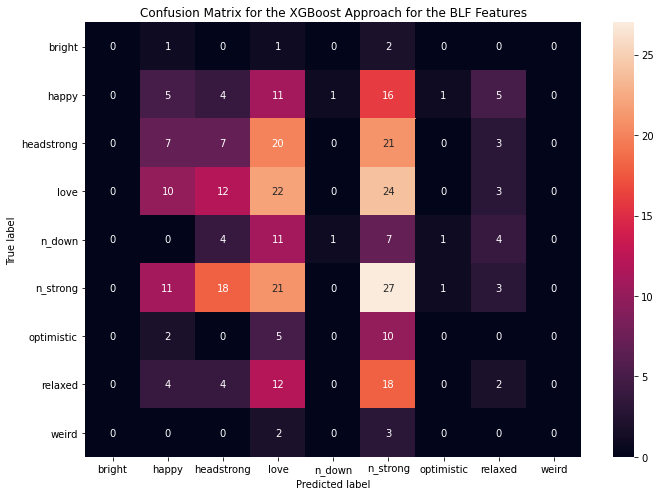

Accuracy = 0.1844380403458213


In [49]:
cm = confusion_matrix(y_test_blf, xgb_predict)
df_cm = pd.DataFrame(cm, index=['bright', 'happy', 'headstrong', 'love', 'n_down', 'n_strong', 'optimistic', 'relaxed', 'weird'],
                     columns=['bright', 'happy', 'headstrong', 'love', 'n_down', 'n_strong', 'optimistic', 'relaxed', 'weird'])
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix for the XGBoost Approach for the BLF Features')
plt.tight_layout()
plt.show()

print("Accuracy =", acc)

# XGB with Both Features

In [50]:
all_feats_train = blf_features_labeled_train.merge(
    ps09_features_labeled_train, on=['SONG_ID', 'MOODS', 'MOODS_ENC'])
all_feats_test = blf_features_labeled_test.merge(
    ps09_features_labeled_test, on=['SONG_ID', 'MOODS', 'MOODS_ENC'])

In [51]:
X_train_all = all_feats_train.drop(['SONG_ID', 'MOODS', 'MOODS_ENC'], axis=1)
y_train_all = all_feats_train['MOODS_ENC']

In [52]:
X_test_all = all_feats_test.drop(['SONG_ID', 'MOODS', 'MOODS_ENC'], axis=1)
y_test_all = all_feats_test['MOODS_ENC']

In [53]:
data_matrix = xgb.DMatrix(X_train_all, y_train_all)

params = {'objective': 'multi:softmax', 'num_class': 9}

trained = xgb.train(params, data_matrix) #train to compute important features

feature_importance = trained.get_score(importance_type='weight')
k = Counter(feature_importance)
feature_importance_table = pd.DataFrame.from_dict(
    k, orient='index').reset_index()
feature_importance_table.columns = ['Features', 'Weights']

In [54]:
# feature importance
fts = feature_importance_table['Features']
fts = pd.DataFrame.from_dict(fts)

weights = feature_importance_table['Weights']
#select the important features out of the rest of them
list_selected_features = fts['Features'].to_list()
all_train_XGB = all_feats_train[np.intersect1d(
    all_feats_train.columns, list_selected_features)]
all_test_XGB = all_feats_test[np.intersect1d(
    all_feats_test.columns, list_selected_features)]

In [55]:
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=9) #classifier trian and predict on the selected features
xgb_model.fit(blf_train_XGB, y_train_blf)
xgb_model.fit(all_train_XGB, y_train_all)
xgb_predict = xgb_model.predict(all_test_XGB)
acc = accuracy_score(y_test_all, xgb_predict)

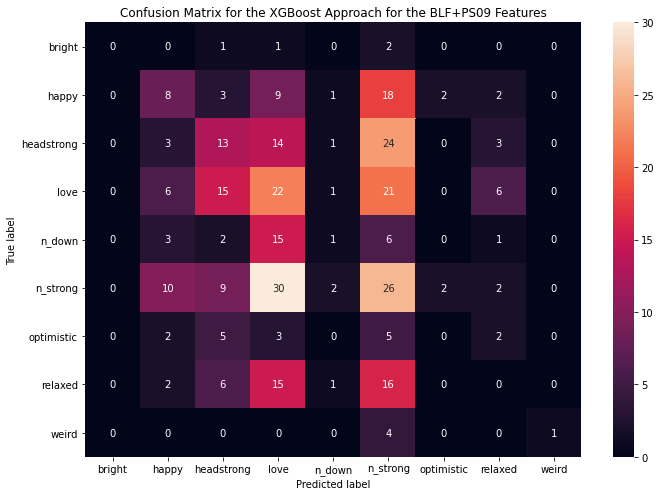

Accuracy = 0.20461095100864554


In [56]:
cm = confusion_matrix(y_test_all, xgb_predict)
df_cm = pd.DataFrame(cm, index=['bright', 'happy', 'headstrong', 'love', 'n_down', 'n_strong', 'optimistic', 'relaxed', 'weird'],
                     columns=['bright', 'happy', 'headstrong', 'love', 'n_down', 'n_strong', 'optimistic', 'relaxed', 'weird'])
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix for the XGBoost Approach for the BLF+PS09 Features')
plt.tight_layout()
plt.show()

print("Accuracy =", acc)

### Checking the correct and incorrect classification (analysis of the results)

In [57]:
song_id = all_feats_test['SONG_ID']
d = {'True': y_test_all, 'Predicted':xgb_predict}
check = pd.DataFrame(d)
check = check.join(song_id)
check.head()

,True,Predicted,SONG_ID
0,5,3,375706
1,7,3,37586
2,7,5,1001321
3,7,3,1004185
4,3,1,380203


# XGB with PS09

In [58]:
X_train_ps09 = ps09_features_labeled_train.drop(
    ['SONG_ID', 'MOODS_ENC', 'MOODS'], axis=1)
y_train_ps09 = ps09_features_labeled_train['MOODS_ENC']

In [59]:
X_test_ps09 = ps09_features_labeled_test.drop(
    ['SONG_ID', 'MOODS_ENC', 'MOODS'], axis=1)
y_test_ps09 = ps09_features_labeled_test['MOODS_ENC']

In [60]:
data_matrix = xgb.DMatrix(X_train_ps09, y_train_ps09)

params = {'objective': 'multi:softmax', 'num_class': 9}

trained = xgb.train(params, data_matrix) #train to compute important features

feature_importance = trained.get_score(importance_type='weight')
k = Counter(feature_importance)
feature_importance_table = pd.DataFrame.from_dict(
    k, orient='index').reset_index()
feature_importance_table.columns = ['Features', 'Weights']

In [61]:
# feature importance
fts = feature_importance_table['Features']
fts = pd.DataFrame.from_dict(fts)

weights = feature_importance_table['Weights']
#select the important features out of the rest of them
list_selected_features = fts['Features'].to_list()
ps09_train_XGB = ps09_features_labeled_train[np.intersect1d(
    ps09_features_labeled_train.columns, list_selected_features)]
ps09_test_XGB = ps09_features_labeled_test[np.intersect1d(
    ps09_features_labeled_test.columns, list_selected_features)]

In [62]:
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=9) #classifier trian and predict on the selected features
xgb_model.fit(blf_train_XGB, y_train_blf)
xgb_model.fit(ps09_train_XGB, y_train_ps09)
xgb_predict = xgb_model.predict(ps09_test_XGB)
acc = accuracy_score(y_test_ps09, xgb_predict)

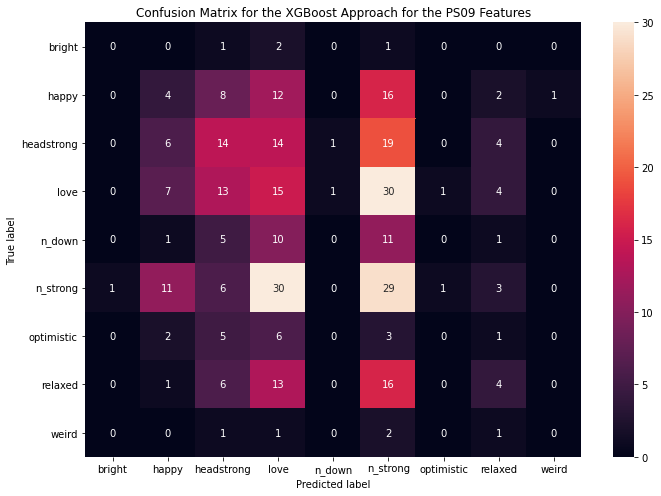

Accuracy = 0.19020172910662825


In [63]:
cm = confusion_matrix(y_test_ps09, xgb_predict)
df_cm = pd.DataFrame(cm, index=['bright', 'happy', 'headstrong', 'love', 'n_down', 'n_strong', 'optimistic', 'relaxed', 'weird'],
                     columns=['bright', 'happy', 'headstrong', 'love', 'n_down', 'n_strong', 'optimistic', 'relaxed', 'weird'])
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix for the XGBoost Approach for the PS09 Features')
plt.tight_layout()
plt.show()

print("Accuracy =", acc)